

---

Email spam dectection 



> 

Import libraies 

In [ ]:
!pip install -U sentence-transformers nlplot pyfpgrowth

import numpy as np
import pandas as pd
import os
import seaborn as sns

In [39]:

# Pre-Processing
import nltk
from nltk.corpus import stopwords
import spacy

In [40]:
#EDA
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import nlplot
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pyfpgrowth
from wordcloud import WordCloud

Output hidden; open in https://colab.research.google.com to view.

In [41]:
# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding,Dropout, Bidirectional, GlobalMaxPool1D,Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from transformers import DistilBertTokenizerFast
from sentence_transformers import SentenceTransformer




---
Importing data set 

In [4]:
for dirname, _, filenames in os.walk('/content/scam gmail.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
df = pd.read_csv("/content/scam gmail.csv", encoding="latin-1")
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [6]:
sms = pd.DataFrame()
sms['message'] = df['v2']
sms['class'] = df['v1']
sms.head(3)

,message,class
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam


splitting the target and independent column

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [23]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [24]:
x=df.v2
x

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

Label Encoding

In [25]:
y=df.v1
y

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5572, dtype: object

In [26]:
y.replace(to_replace='ham',value=1,inplace=True)
y.replace(to_replace='spam',value=0,inplace=True)
y

0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: v1, Length: 5572, dtype: int64

checking the ratio

In [27]:
y=df.v1
y.value_counts()

1    4825
0     747
Name: v1, dtype: int64

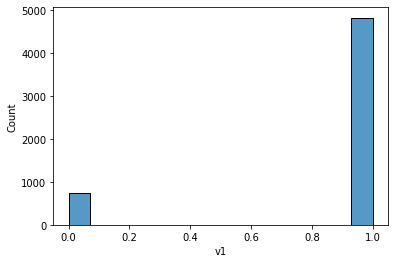

In [55]:
sns.histplot(y)

In [7]:
sms.shape

(5572, 2)

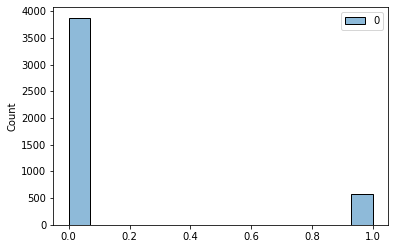

In [56]:
sns.histplot(y_train)


train encodings

In [12]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(sms.message.tolist(),add_special_tokens = True, truncation = True,  padding = True, return_tensors="tf")

In [13]:
x = np.array(train_encodings['input_ids'])
y = pd.get_dummies(sms["class"])
y = np.array(y)
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train,x_valid,y_train,y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [14]:
model = Sequential()
model.add(Embedding(tokenizer.vocab_size, 100, input_length=300))
model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)))
model.add(Conv1D(16, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform"))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(2,activation = 'softmax'))
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          3052200   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 32)          14976     
 l)                                                              
                                                                 
 conv1d (Conv1D)             (None, 298, 16)           1552      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                850       
                                                                 
 dropout (Dropout)           (None, 50)                0



---

train test split

In [44]:
x_train

array([[-0.15675066,  0.02556193, -0.6226552 , ...,  0.27179223,
        -0.251665  ,  0.17689216],
       [ 0.42049026, -0.20244198, -0.10455825, ...,  0.05116082,
        -0.6660584 ,  0.00262572],
       [ 0.10669673,  0.35695174, -0.3200309 , ...,  0.0278357 ,
        -0.6781071 , -0.15893969],
       ...,
       [ 0.09101059, -0.04737726,  0.4483802 , ...,  0.18043606,
        -0.9240221 , -0.03776861],
       [ 0.21712905, -0.47816372,  0.25216353, ..., -0.01907505,
        -0.5883471 , -0.4238879 ],
       [-0.03227955,  0.21861328,  0.17421356, ...,  0.4086887 ,
        -0.20330766, -0.17642115]], dtype=float32)

In [45]:
y_train.astype

<function ndarray.astype>

In [50]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score


In [52]:
gnb= GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()
gnb.fit(x_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [51]:
y_pred1=gnb.predict(x_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.9390134529147982
[[896  53]
 [ 15 151]]
0.7401960784313726
